## 9 - Creating Motion Paths and Flowlines

In this notebook, we will show how GPlately's `PlateReconstruction` object:
- Creates a motion path of points to illustrate the trajectory of a tectonic plate through geological time, and
- Quantifies the rate of motion of a tectonic plate through time.

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import cartopy.crs as ccrs
import matplotlib
from matplotlib import image
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import LineString
import geopandas as gpd

Let's use the global rotation model (`rotation_model`) and plate polygons (`topology_features`) associated with Seton et al. (2012): 

Seton, M., Müller, R. D., Zahirovic, S., Gaina, C., Torsvik, T., Shephard, G., Talsma, A., Gurnis, M., Turner, M., Maus, S., Chandler, M. (2012). Global continental and ocean basin reconstructions since 200 Ma. Earth-Science Reviews, 113(3), 212-270. doi:10.1016/j.earscirev.2012.03.002

Let's call the `PlotTopologies` object for our maps later:

In [2]:
# Request Seton et al. 2012 from DataServer
gdownload = gplately.download.DataServer("Seton2012")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Call the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
No static polygons in Seton2012.


In [3]:
# Get Seton et al. (2012) coastlines, continents and COBs if they are available. 
# We don't use them in this notebook, though!
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continents in Seton2012.


### 1. The motion path of a Hawaiian seed point
Consider the latitude and longitude of present-day Hawaii (19, -155) (in degrees). It is located on the Pacific Plate, which we allocate the `relative_plate_ID` = 901. Let's use `create_motion_path` to reconstruct this seed point's location atop the Pacific Plate as it moves through geological time. We consider rotations under `reconstruction_plate_ID` = 2.

### Quantifying the rate of plate motion
...can be done with `create_motion_path` by setting `return_rate_of_motion` to `True`. This returns an additional array of the rate of motion of the moving plate with respect to the chosen reference plate ID. Let's plot this on an additional subplot.

In [10]:
# Latitude and longitude array 
lats = np.array([19])
lons = np.array([-155])

# Plate ID attributes
relative_plate_ID = 901
reconstruction_plate_ID = 2

# Create the time array for the motion path
start_reconstruction_time = 0
time_step = 2
max_reconstruction_time = 100
time_array = np.arange(start_reconstruction_time, max_reconstruction_time + time_step, time_step)

# Get the latitudes and longitudes of all points along the motion path
lon, lat, rates_of_motion = model.create_motion_path(
    lons, lats, time_array, relative_plate_ID, reconstruction_plate_ID, return_rate_of_motion=True)

Let's plot this motion path with the ETOPO1 global topology and bathymetry model. We can download this grid to the GPlately cache using DataServer:

In [5]:
etopo_tif_img = gdownload.get_raster("ETOPO1_tif")

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [6]:
# gplately Points alternative
gpts = gplately.Points(model, lons, lats, time=0, plate_id=[relative_plate_ID])
lon, lat, rates_of_motion = gpts.motion_path(time_array, anchor_plate_id=reconstruction_plate_ID, return_rate_of_motion=True)

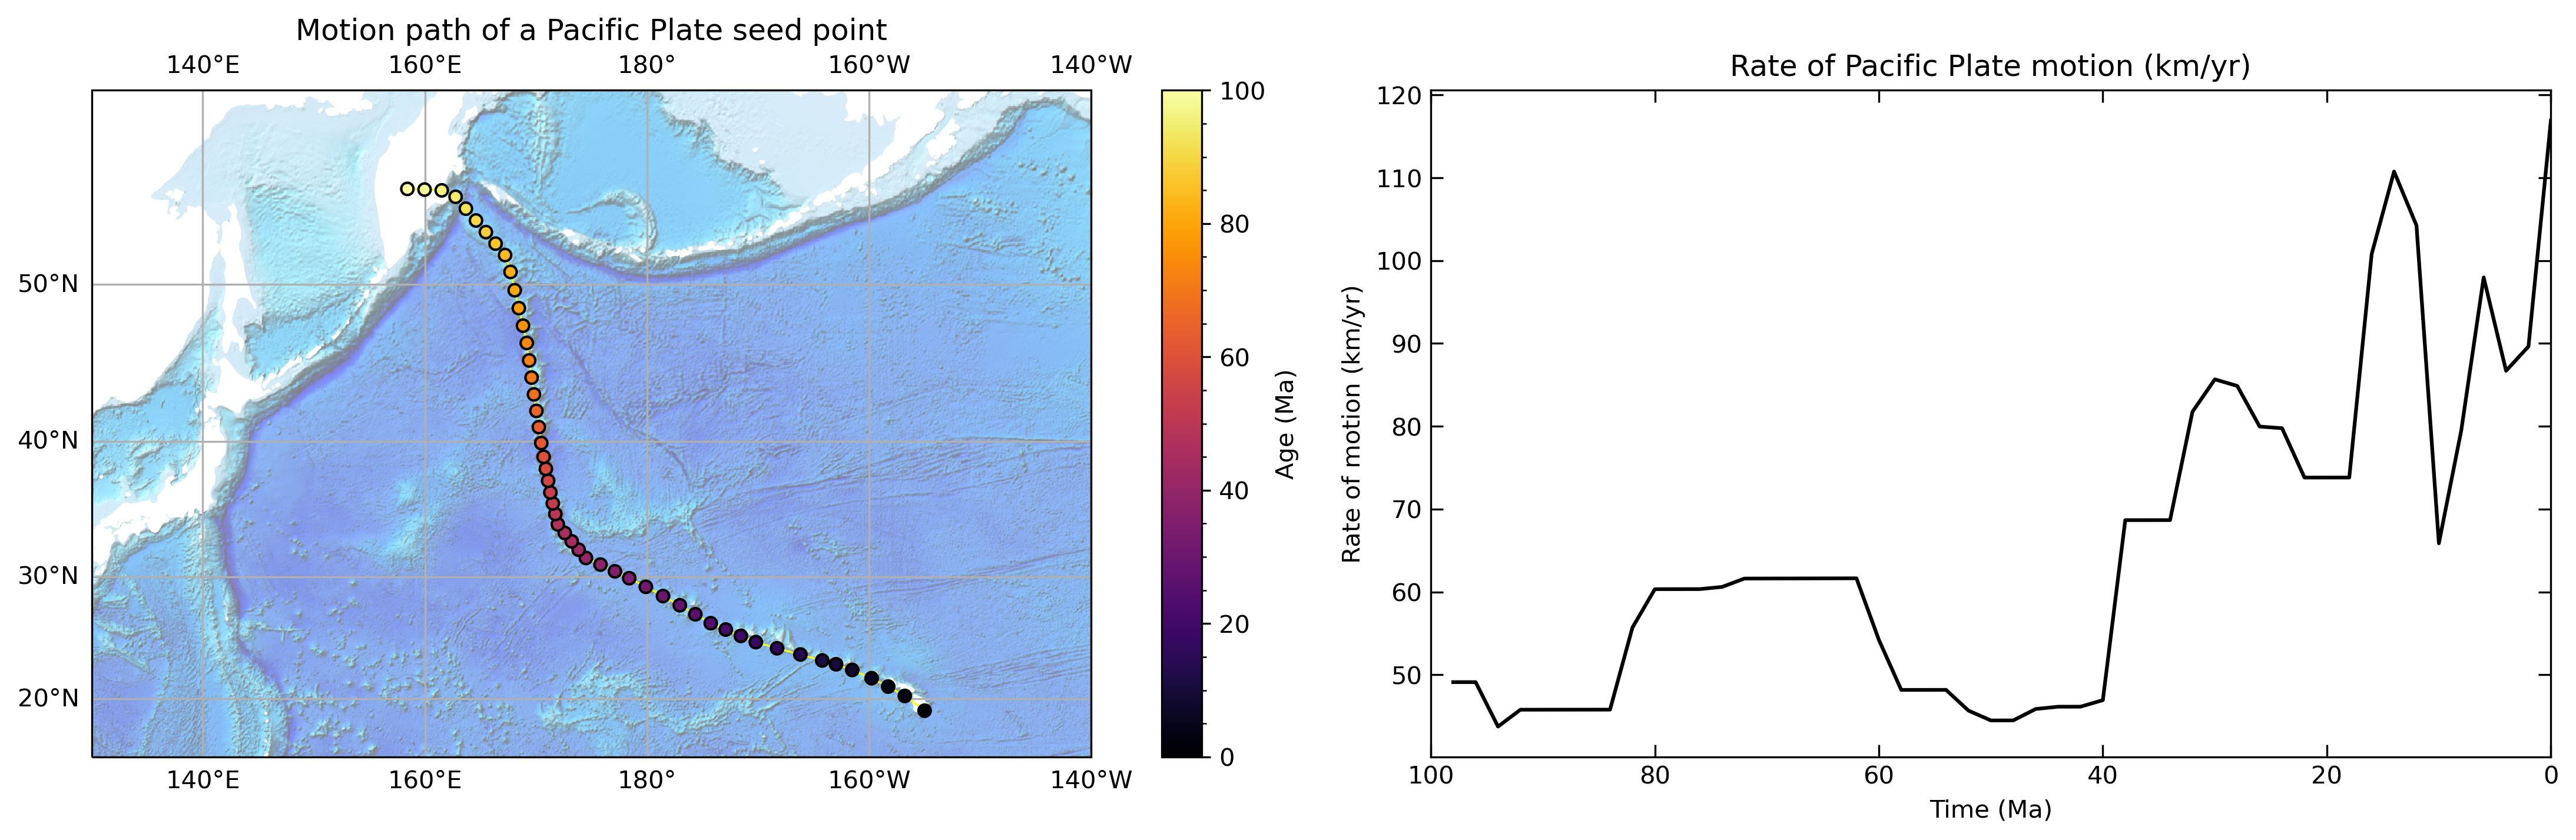

In [11]:
# --- Create figure
fig = plt.figure(figsize=(18, 5), dpi=300)
ax = fig.add_subplot(121, projection=ccrs.Mercator(central_longitude=180))
ax.set_title("Motion path of a Pacific Plate seed point")

# --- Limit map extent
lon_min = 130.
lon_max = 220  # if I specify as -150, it will plot as the 'other' way around the world
lat_min = 15.
lat_max = 60.
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, xlocs=np.arange(-180,180,20), ylocs=np.arange(-90,90,10))


# ---- Plot bathymetry
img_extent = (-180, 180, -90, 90)
ax.imshow(etopo_tif_img, cmap='Greys_r', origin='upper', extent=img_extent, alpha=0.5,
          transform=ccrs.PlateCarree(central_longitude=0), zorder=1)

# --- Plot filled coastlines
ax.add_feature(cfeature.LAND, color='white', zorder=2)

# --- plot motion path
lon360 = lon.copy()
lon360[lon < 0] += 360 # correct for dateline
ax.plot(lon360, lat, color='yellow', linewidth=0.75, transform=ccrs.PlateCarree(), zorder=3)
mp = ax.scatter(lon360, lat, 100, marker='.', c=time_array, cmap=plt.cm.inferno, edgecolor='k',
                transform=ccrs.PlateCarree(), vmin=time_array[0], vmax=time_array[-1], zorder=4)
    
# --- Set a colorbar to help visualise the passage of every Xth Myr.
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="4%", pad=0.4, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(mp, cax=cax, orientation="vertical")
cbar.set_label('Age (Ma)')
cbar.ax.minorticks_on()

# --- Plot rate of motion on 2nd subplot
p = fig.add_subplot(122, xlabel='Time (Ma)', ylabel='Rate of motion (km/yr)', xlim=[max_reconstruction_time, 0])
p.set_title("Rate of Pacific Plate motion (km/yr)")
p.tick_params(direction="in", length=5, top=True, right=True)
p.plot(time_array[:-1], rates_of_motion, color='k')

plt.show()

### 2. The motion path of several seed points 

In [21]:
lats = np.array([30, 30, 30])
lons = np.array([73, 78, 83])

# Plate ID attributes
# motion of the Indian craton (501) with respect to the Northern European craton (301)
relative_plate_ID = 301
reconstruction_plate_ID = 501 

# Create the time array for the motion path
start_reconstruction_time = 0
time_step = 2
max_reconstruction_time = 91
time_array = np.arange(start_reconstruction_time, max_reconstruction_time + time_step, time_step)

# Get the latitudes and longitudes of all points along the motion path
lon, lat, rate_of_motion = model.create_motion_path(
    lons, lats, time_array, reconstruction_plate_ID, relative_plate_ID, 
    return_rate_of_motion=True)

/Users/ben/miniforge3/envs/mapping/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


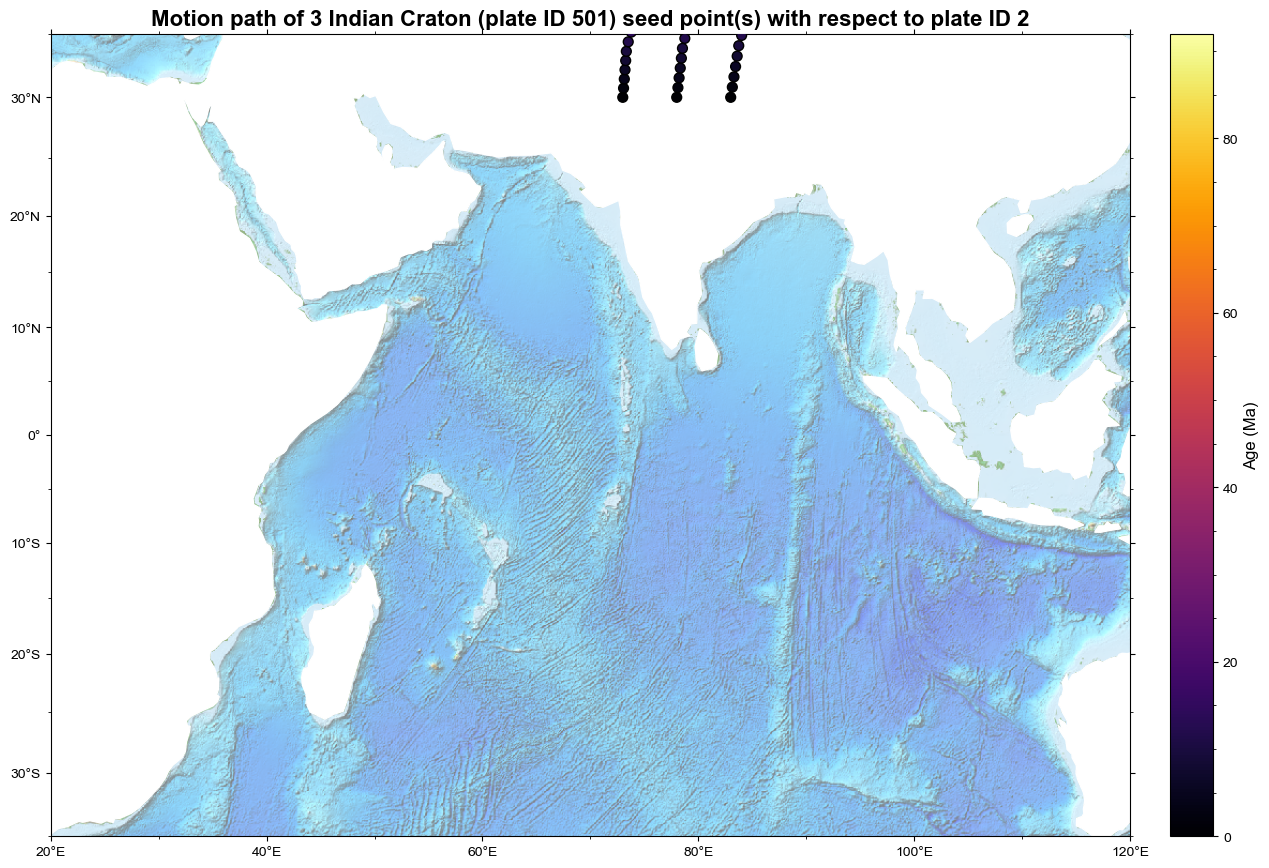

In [22]:
# --- Create figure
fig = plt.figure(figsize=(15,15), dpi=100)
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_subplot(111, projection=ccrs.Mercator(central_longitude=180))
ax.set_title(
    "Motion path of {} Indian Craton (plate ID 501) seed point(s) with respect to plate ID 2".format(len(lons)), 
    fontsize=16,
    weight="demi")

# --- Plot tick labels
ax.set_xticks(np.arange(0, 360, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 100, 10), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(0, 360, 10), minor=True, crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 5), minor=True, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.tick_bottom()  # labelled ticks on top
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_ticks_position('both')   # ticks on both top/bottom
ax.yaxis.set_ticks_position('both')   # ticks on both left/right

# --- Limit map extent
lon_min = 120.
lon_max = 20  # if I specify as -150, it will plot as the 'other' way around the world
lat_min = -35.
lat_max = 35.
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())


# ---- Plot bathymetry
img_extent = (-180, 180, -90, 90)
ax.imshow(etopo_tif_img, cmap='Greys_r', origin='upper', extent=img_extent, alpha=0.5,
          transform=ccrs.PlateCarree(central_longitude=0), zorder=1)

# --- Plot filled coastlines
ax.add_feature(cfeature.LAND, color='white', zorder=2)

# --- plot motion path
for i in np.arange(0,len(lons)):
    ax.plot(lon[:,i], lat[:,i], color='yellow', linewidth=0.75, transform=ccrs.PlateCarree(), zorder=3)
    mp = ax.scatter(lon[:,i], lat[:,i], 200, marker='.', c=time_array, cmap=plt.cm.inferno, edgecolor='k',
                    transform=ccrs.PlateCarree(), vmin=time_array[0], vmax=time_array[-1], zorder=4)
    
# --- Set a colorbar to help visualise the passage of every Xth Myr.
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="4%", pad=0.4, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(mp, cax=cax, orientation="vertical")
cbar.set_label('Age (Ma)', fontsize=12)
cbar.ax.minorticks_on()

plt.show()

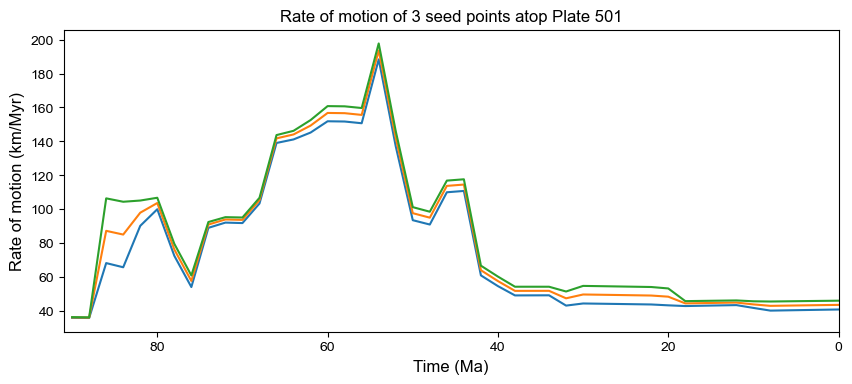

In [9]:
fig = plt.figure(figsize=(10,4), dpi=100)
plt.title("Rate of motion of {} seed points atop Plate {}".format(len(lons), reconstruction_plate_ID))
for i in np.arange(0,len(lons)):
    plt.plot(time_array[:-1], rate_of_motion[:,i], color='C{}'.format(i))
    plt.xlabel('Time (Ma)', fontsize=12)
    plt.ylabel('Rate of motion (km/Myr)', fontsize=12)
plt.gca().invert_xaxis()
plt.xlim([max_reconstruction_time, 0])
plt.show()

### 2. Flowlines from a mid-ocean ridge in the South Atlantic
A flowline is a series of point locations reconstructed through time to track the motion of tectonic plates from spreading features like mid-ocean ridges. 

We can generate one or more flowlines with `create_flowline` from GPlately's `PlateReconstruction` object. All we need is an array of latitudes and longitudes of points along a mid-ocean ridge, the IDs of the plate to the left and right of the mid-ocean ridge, and an array of reconstruction times.

In [10]:
# Longitudes and latitudes of points along the South Atlantic mid ocean ridge
lons = np.array([-15.4795, -14.9688, -14.0632, -17.7739])
lats = np.array([-1.60584,-11.9764, -25.7209, -35.7228])

# Left and right plate IDs
left_plate_ID = 201
right_plate_ID = 701

# Constructing the time array
time_step = 2.5
max_reconstruction_time = 120
time_array = np.arange(0, max_reconstruction_time+time_step, time_step)

# Generate the latitudes and longitude coordinates of the flowlines to the left and right of the MOR!
left_lon, left_lat, right_lon, right_lat = model.create_flowline(
    lons,
    lats,
    left_plate_ID,
    right_plate_ID,
    time_array
)

Let's illustrate these flowlines with mid-ocean ridge/transform boundaries from Seton et al. (2012) using the `PlotTopologies` object.

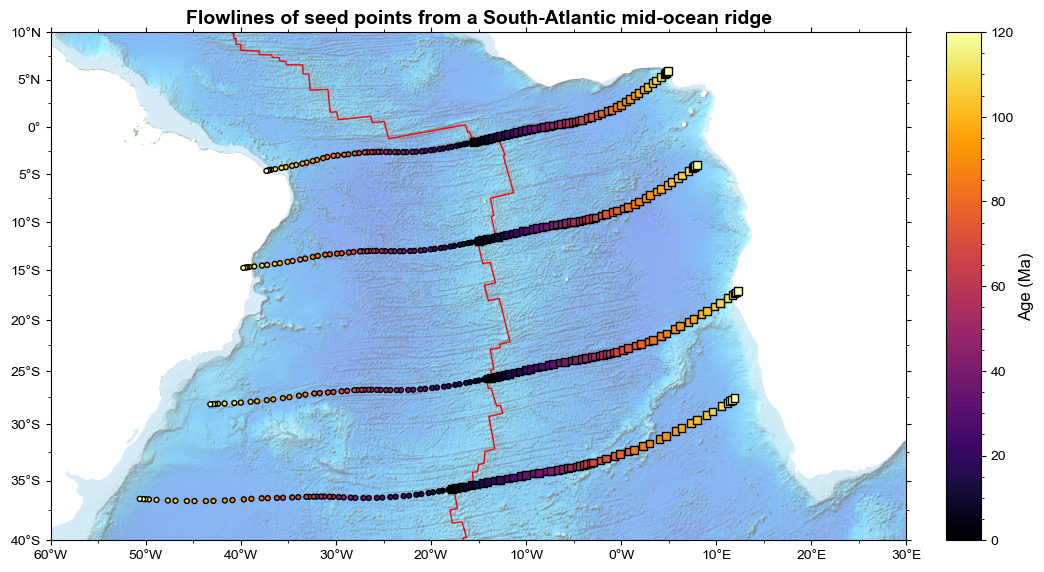

In [11]:
# --- Create figure
fig = plt.figure(figsize=(12, 12), dpi=100)
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_title("Flowlines of seed points from a South-Atlantic mid-ocean ridge", fontsize=14, weight="demi")

# --- Plot tick labels. This doesn't work for all projections in cartopy yet...
ax.set_xticks(np.arange(-180, 190, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 95, 5), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-180, 185, 5), minor=True, crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 2.5), minor=True, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.tick_bottom()  # labelled ticks on top
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_ticks_position('both')   # ticks on both top/bottom
ax.yaxis.set_ticks_position('both')   # ticks on both left/right

# --- Limit map extent
lon_min = -60
lon_max = 30
lat_min = -40.
lat_max = 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# ---- Plot bathymetry
ax.imshow(etopo_tif_img, cmap='Greys_r', origin='upper', extent=img_extent, alpha=0.5,
          transform=ccrs.PlateCarree(), zorder=1)

# --- Plot filled coastlines
ax.add_feature(cfeature.LAND, color='white', zorder=2)
gplot.plot_ridges_and_transforms(ax, color="r", linewidth=1)

# --- Iterate over the reconstructed flowlines. Each seed point results in a 'left' and 'right' flowline 
for i in np.arange(0,len(lons)):
     
    # plot left flowlines as circles
    fl = ax.scatter(left_lon[:,i], left_lat[:,i], 50, marker='.', c=time_array,
                    transform=ccrs.PlateCarree(), cmap=plt.cm.inferno, edgecolor='k',
                    vmin=time_array[0], vmax=time_array[-1], zorder=3)
    
    # plot right flowlines as squares
    ax.scatter(right_lon[:,i], right_lat[:,i], 30, marker='s',c=time_array,
               transform=ccrs.PlateCarree(), cmap=plt.cm.inferno, edgecolor='k',
               vmin=time_array[0], vmax=time_array[-1], zorder=3)
    
# --- Set a colorbar to help visualise the passage of every Xth Myr.
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="4%", pad=0.4, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(fl, cax=cax, orientation="vertical")
cbar.set_label('Age (Ma)', fontsize=12)
cbar.ax.minorticks_on()

plt.show()